## Классические алгоритмы без ансамблирования
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.75$ - 0 баллов
- $0.75 < AUC \leq 0.76$ - 2 балла
- $0.76 < AUC \leq 0.77$ - 4 балла
- $0.77 < AUC \leq 0.78$ - 6 баллов
- $0.78 < AUC \leq 0.79$ - 8 баллов
- $AUC > 0.79$ - 10 баллов

\
В этой работе запрещено использовать ансамбли моделей (лес, бустинги и т.д.)!

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV # для оптимизации гиперпараметров
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn import decomposition, datasets
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint
from imblearn.over_sampling import SMOTE

from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [16]:
data = pd.read_csv('german.csv', sep=';')
print(data.head())

X = data.iloc[:, 1:]
X = X.to_numpy() 
Y = data.iloc[:, 0]
y = Y.to_numpy()
smote = SMOTE(random_state=1000)
X_, y_ = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
#test_size - доля набора данных, включаемая в тестовое разделение
#train_size - доля набора данных, включаемая в тренировочное разделение(если мы уже явно установили 
#                                               test_size, то этот параметр можно не устанавливать)
#random_state - управляет перетасовкой, применяемой к данным перед разделением, чтобы они были не предвзяты

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

In [6]:
data

,Creditability,Account_Balance,Duration_of_Credit_monthly,Payment_Status_of_Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,Length_of_current_employment,Instalment_per_cent,Sex_Marital_Status,...,Duration_in_Current_address,Most_valuable_available_asset,Age_years,Concurrent_Credits,Type_of_apartment,No_of_Credits_at_this_Bank,Occupation,No_of_dependents,Telephone,Foreign_Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,24,2,3,1987,1,3,2,3,...,4,1,21,3,1,1,2,2,1,1
996,0,1,24,2,0,2303,1,5,4,3,...,1,1,45,3,2,1,3,1,1,1
997,0,4,21,4,0,12680,5,5,4,3,...,4,4,30,3,3,1,4,1,2,1
998,0,2,12,2,3,6468,5,1,2,3,...,1,4,52,3,2,1,4,1,2,1


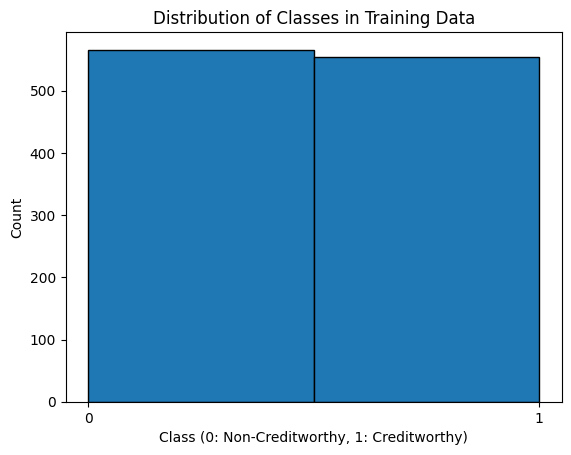

In [17]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()
#гистаграмма распределения классов в датасете(колличество элементов класса 0 и 1)

In [20]:
# Создание модели Logistic Regression
logistic_regression_model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_leaf': [1, 2, 4]
# }
logistic_regression_model_random = GridSearchCV(estimator=logistic_regression_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)

# param_grid = {
# 'C': [0.001, 0.01, 0.1, 1, 10, 100],
# 'penalty': ['l1', 'l2']
# }

# # Создание объекта Grid Search с кросс-валидацией
# grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5)
logistic_regression_model = logistic_regression_model_random.fit(X_train, y_train)
#начало обучения
#Подбор модели в соответствии с данными обучения

# Создание модели Decision Tree
decision_tree_model = DecisionTreeClassifier()
#удаление контуров и масштабирования данных, принимая среднее значение данных равным 0, а стандартное отклонение — 1
# std_slc = StandardScaler()
# # анализ главных компонентов (PCA) позволяет уменьшить размерность объектов за счет создания 
# # новых объектов, которые имеют большую часть отклонений от исходных данных
# pca = decomposition.PCA() 
# #
# pipe = Pipeline(steps=[('std_slc', std_slc),
#                            ('pca', pca),
#                            ('dec_tree', decision_tree_model)])
# n_components = list(range(1,X.shape[1]+1,1))
# criterion = ['gini', 'entropy']
# max_depth = [2,4,6,8,10,12]
# parameters = dict(pca__n_components=n_components,
# dec_tree__criterion=criterion,
# dec_tree__max_depth=max_depth)
# clf_GS = GridSearchCV(pipe, parameters)
# decision_tree_model = clf_GS.fit(X_train, y_train)

parameters = {
'criterion': ['gini', 'entropy'],
'max_depth': [None, 5, 10, 15],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4]
}

# # Поиск по сетке, используя кросс-валидацию
grid_search = GridSearchCV(decision_tree_model, parameters, cv=5)
decision_tree_model = grid_search.fit(X, y)


# Создание модели K-Nearest Neighbors
knn_model = KNeighborsClassifier()
# n_neighbors = range(1, 13, 10)
# weights = ['uniform', 'distance']
# metric = ['euclidean', 'manhattan', 'minkowski']
# grid = dict(n_neighbors=n_neighbors,weights=weights,metric=metric)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=10)
# grid_search = GridSearchCV(estimator=knn_model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# knn_model = grid_search.fit(X_train, y_train)

pipeline = Pipeline([
('scaler', StandardScaler()),
('knn', knn_model)
])

# Define the grid of hyperparameters to search
parameters = {
'knn__n_neighbors': [3, 5, 7, 9],
'knn__weights': ['uniform', 'distance'],
'knn__p': [1, 2]
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(pipeline, parameters, cv=5)
knn_model = grid_search.fit(X, y)

In [21]:
y_prob_logistic = logistic_regression_model.predict_proba(X_test)[:, 1]
y_prob_decision_tree = decision_tree_model.predict_proba(X_test)[:, 1]
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

y_pred_logistic = logistic_regression_model.predict(X_test)
y_pred_decision_tree = decision_tree_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_decision_tree = accuracy_score(y_test, y_pred_decision_tree)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
roc_auc_decision_tree = roc_auc_score(y_test, y_prob_decision_tree)
roc_auc_knn = roc_auc_score(y_test, y_prob_knn)

precision_logistic = precision_score(y_test, y_pred_logistic)
precision_decision_tree = precision_score(y_test, y_pred_decision_tree)
precision_knn = precision_score(y_test, y_pred_knn)

recall_logistic = recall_score(y_test, y_pred_logistic)
recall_decision_tree = recall_score(y_test, y_pred_decision_tree)
recall_knn = recall_score(y_test, y_pred_knn)

print(f'Accuracy of Logistic Regression: {accuracy_logistic}')
print(f'Accuracy of Decision Tree: {accuracy_decision_tree}')
print(f'Accuracy of K-Nearest Neighbors: {accuracy_knn}')

print(f'ROC AUC of Logistic Regression: {roc_auc_logistic}')
print(f'ROC AUC of Decision Tree: {roc_auc_decision_tree}')
print(f'ROC AUC of K-Nearest Neighbors: {roc_auc_knn}')

print(f'Precision of Logistic Regression: {precision_logistic}')
print(f'Precision of Decision Tree: {precision_decision_tree}')
print(f'Precision of K-Nearest Neighbors: {precision_knn}')

print(f'Recall of Logistic Regression: {recall_logistic}')
print(f'Recall of Decision Tree: {recall_decision_tree}')
print(f'Recall of K-Nearest Neighbors: {recall_knn}')

Accuracy of Logistic Regression: 0.7607142857142857
Accuracy of Decision Tree: 0.75
Accuracy of K-Nearest Neighbors: 0.7321428571428571
ROC AUC of Logistic Regression: 0.8618891842159068
ROC AUC of Decision Tree: 0.8619658556532407
ROC AUC of K-Nearest Neighbors: 0.8938356164383563
Precision of Logistic Regression: 0.7801418439716312
Precision of Decision Tree: 0.7087912087912088
Precision of K-Nearest Neighbors: 0.6802030456852792
Recall of Logistic Regression: 0.7534246575342466
Recall of Decision Tree: 0.8835616438356164
Recall of K-Nearest Neighbors: 0.9178082191780822


## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели